# Best Practices for Model Evaluation and Hyperparameter Tuning

## Streamlining workflows with pipelines

When working on a dataset we saw that we have to reuse the parameters that were obtained during the fitting of the training data. We will learn how to use the **Pipeline** class in scikit-learn for this.

### Loading a dataset

We will be working with the [**Breast Cancer Wisconsin**](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin) dataset which contains 569 samples of malignant and benign tumor cells.

We will read the dataset and split it into training and test sets

In [1]:
import pandas as pd

df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', 
    header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Now we assign the 30 features to a NumPy array **x**, then by using [**LabelEncoder**](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) we transform the class labels from their original string representation (**M** and **B**) to integers (1 and 0).

We create 2 NumPy arrays from the **pandas DataFrame**, in **x** we keep all the features of the dataset (from column 3 onward) and in **y** we get only labels (column 2).

In [2]:
from sklearn.preprocessing import LabelEncoder

# We get just the values from every column
# In column 0 there are only IDs
x = df.loc[:, 2:].values 
y = df.loc[:, 1].values

# Create a LabelEncoder object and transform labels
le = LabelEncoder()
y = le.fit_transform(y)

Now the two classes are encoded as **1 = M** and **0 = B**. To check if the behaviour is correct we can call the method on two dummy examples. 

> Notice that by calling the **transform** method on the object used to fit the encoder (or other transformations) we can transform new data coming in.

In [3]:
le.transform(['M', 'B'])

array([1, 0])

Before constructing the first model pipeline let's divide data into training and test sets

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=1)

### Combining transformers and estimators in a pipeline

As we learned previously, we want to standardize the features of the model before running it. So, let's assume that we want to compress our data from 30 dimensions onto a lower two-dimensional subspace via PCA. Instead of going through the transformation steps we can chain the [**StandardScaler**](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), [**PCA**](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and [**LogisticRegression**](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) in a [**Pipeline**](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [6]:
pipe_lr = Pipeline([('scl', StandardScaler()), 
                    ('pca', PCA(n_components=2)), 
                    ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(x_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(x_test, y_test))

Test Accuracy: 0.947


The **Pipeline** object takes a list of tuples as input where the first element is an ID used to access single elements in the pipeline, and the second element is a scikit-learn transformer or estimator.

## Cross-validation

To avoid overfitting we can use **cross-validation**. There are two major techniques: **holdout cross-validation** and **k-fold cross-validation**.

### Holdout method

By splitting the dataset into training and test datasets and performing model selection and hyperparameter tuning on the same test set we make it become training data. A better way to use the **holdout method** is to split data into training, validation and test set.

The issue with this method is that it will depend on the split of the data, and it can be impractical for small data problems.

### K-fold cross-validation

In **k-fold cross-validation** we randomly split the training dataset into *k* folds without replacement, where $k-1$ folds are used for model training and one fold is used for testing. The procedure is repeated *k* times. 

The default value for *k* is 10 which is a reasonable number for many datasets, for small ones we can increase *k*, in this way more data will be used for training every iteration.

For classification problems we can improve k-fold performance with **Stratified k-fold** which tends to perform better with unequal class proportions. In fact with this method every fold retains the proportion of classes.

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [8]:
kfold = StratifiedKFold(n_splits=10,
                        random_state=1).split(x_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(x_train[train], y_train[train])
    score = pipe_lr.score(x_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [9]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


Though the previous code is useful to understand how k-fold works under the hood, we have a better and faster implementation implemented in scikit-learn.

In [10]:
from sklearn.model_selection import cross_val_score

In [11]:
scores = cross_val_score(estimator=pipe_lr,
                        X=x_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


In [12]:
print('CV accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy 0.950 +/- 0.029


## Debugging algorithms with learning and validation curves

We will now take a look at the performance of algorithms via **learning curves** and **validation curves**.

### Diagnosing bias and variance problems with learning curves

If a model is too complex for the underlying data it will likely overfit on training data and won't generalize well to unseen data. We can solve the issue by collecting more data, but since this could be expensive and/or unfeasible we may want to check whether collecting more data could help us.

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 7.0)

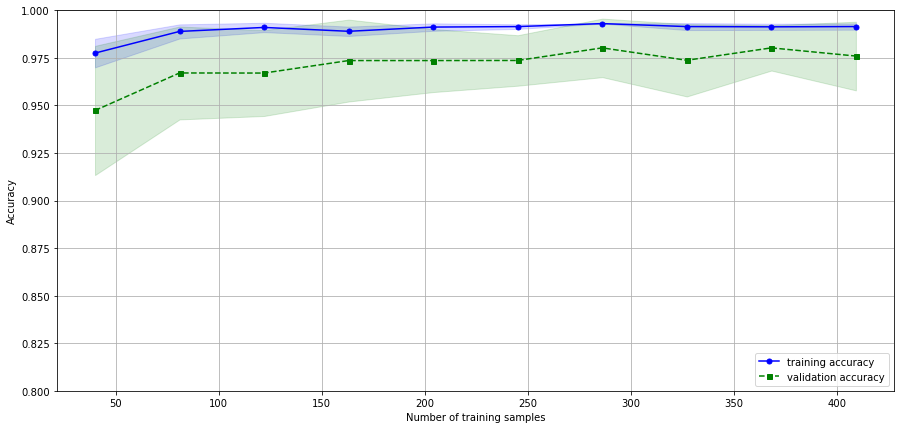

In [14]:
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2', random_state=0))
])
train_sizes, train_scores, test_scores = \
    learning_curve(
        estimator=pipe_lr,
        X=x_train,
        y=y_train,
        train_sizes=np.linspace(.1, 1.0, 10),
        cv=10,
        n_jobs=-1
    )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
    train_sizes, 
    train_mean,
    color='blue', 
    marker='o',
    markersize=5, 
    label='training accuracy'
)
plt.fill_between(
    train_sizes,
    train_mean + train_std,
    train_mean - train_std,
    alpha=.15,
    color='blue'
)
plt.plot(
    train_sizes,
    test_mean,
    color='green',
    linestyle='--',
    marker='s',
    markersize=5,
    label='validation accuracy'
)
plt.fill_between(
    train_sizes,
    test_mean + test_std,
    test_mean - test_std,
    alpha=.15,
    color='green'
)
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([.8, 1.0])
plt.show()

With [**learning_curve**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) we can control the absolute or relative number of training samples used to generate the learning curves. **train_sizes** here are set to use 10 evenly spaced relative intervals.

As we can see the model performs quite well on the test dataset, though there might be some overfitting indicated by a small, but visible gap between training and **cv** accuracy.

### Addressing overfitting and underfitting with validation curves

**Validation curves** are useful to evaluate models, since instead of plotting the training and test accuracies as functions of sample size, we vary the model paramters and see how performance changes.

In [15]:
from sklearn.learning_curve import validation_curve

/home/alan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/alan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


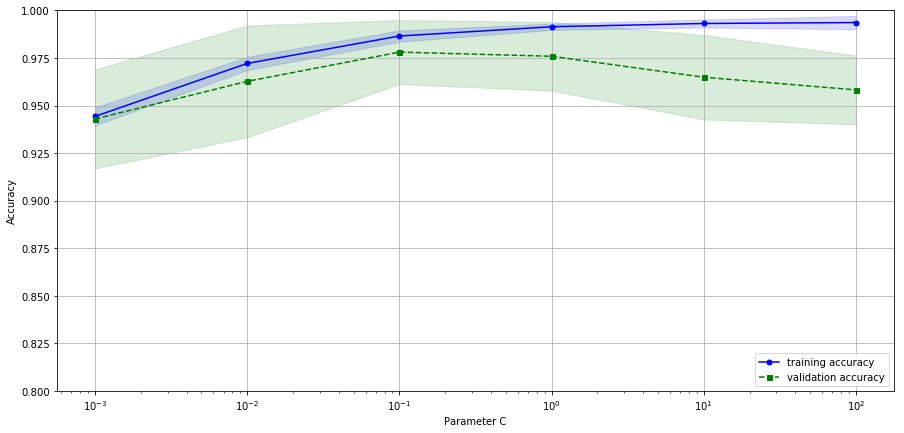

In [16]:
param_range = [.001, .01, .1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=x_train,
    y=y_train,
    param_name='clf__C',
    param_range=param_range,
    cv=10
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
    param_range, 
    train_mean,
    color='blue', 
    marker='o',
    markersize=5, 
    label='training accuracy'
)
plt.fill_between(
    param_range,
    train_mean + train_std,
    train_mean - train_std,
    alpha=.15,
    color='blue'
)
plt.plot(
    param_range,
    test_mean,
    color='green',
    linestyle='--',
    marker='s',
    markersize=5,
    label='validation accuracy'
)
plt.fill_between(
    param_range,
    test_mean + test_std,
    test_mean - test_std,
    alpha=.15,
    color='green'
)
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([.8, 1.0])
plt.show()

Similar to learning curve the [**validation_curve**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html) we specify the parameter we want to evaluate, in this case **C**.

> To access the parameter directly from the pipeline we git to the **validation_curve** function as *param_name* 'clf\_\_C' telling the function we want to modify the **C** paramater inside the 'clf' object in the pipeline. We can modify every step of the pipeline and any parameter in this way

## Grid Search

What we did before was testing the value of one parameter of a model, with **grid search** our aim is to find the optimal combination of hyperparameter values.

### Tuning hyperparameters via grid search

Grid search is a brute force exhaustive search paradigm where we specify a list of values for various parameters and the computer evaluates the performance for each combination.

In [17]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

/home/alan/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [18]:
pipe_svc = Pipeline([
    ('scl', StandardScaler()),
    ('clf', SVC(random_state=1))
])
param_range = [.0001, .001, .01, .1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']}, 
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    n_jobs=-1
)
gs = gs.fit(x_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


To recap: we initialized a [**GridSearchCV**](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) object to train and tune a [**Support Vector Machine (SVM)**](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) pipeline. We set a list of dictionaries for the *param\_grid* argument to specify a set of parameters that we want to tune.

Now we will use the *best\_params\_* coming out of grid search to check model performance on the test set.

In [19]:
clf = gs.best_estimator_
clf.fit(x_train, y_train)
print('Test score: %.3f' % clf.score(x_test, y_test))

Test score: 0.965


### Algorithm selection with nested cross validation

When we want to evaluate different algorithms we can use **nested cross-validation**: we basically have an outer k-fold cross-validation loop to split data into training and test sets, and an inner loop using k-fold on the training fold to select the model.

In [20]:
gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=2,
    n_jobs=-1
)
scores = cross_val_score(
    gs, 
    x_train,
    y_train, 
    scoring='accuracy',
    cv=5
)
print('CV accuracy: %.3f +/- %.3f' % (
    np.mean(scores),
    np.std(scores)
))

CV accuracy: 0.965 +/- 0.025


What we did there was **5x2** cross-validation, a widely used technique. In this way we get a sense of what to expect when using the model on unseen data.

Now we will compare SVM with a decision tree:

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=[{
        'max_depth': [1,2,3,4,5,6,7,None]
    }],
    scoring='accuracy',
    cv=5
)
scores = cross_val_score(
    gs, 
    x_train,
    y_train,
    scoring='accuracy',
    cv=2
)
print('CV accuracy: %.3f +/- %.3f' % (
    np.mean(scores),
    np.std(scores)
))

CV accuracy: 0.906 +/- 0.015


## Looking at different performance evaluation metrics

To measure the performance of a model up to now we used just accuracy, but there are other important measures such as **precision**, **recall** and the **F1 score**.

### Confusion matrix

A **confusion matrix** is a square matrix reporting the counts of **true positive**, **true negative**, **false positive** and **false negative**. Though we can easily calculate these metrics, scikit-learn provides a [**confusion_matrix**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
pipe_svc.fit(x_train, y_train)
y_pred = pipe_svc.predict(x_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


We can use the [**matshow**](http://matplotlib.org/2.0.0/api/pyplot_api.html#matplotlib.pyplot.matshow) to visualize the array we got in return

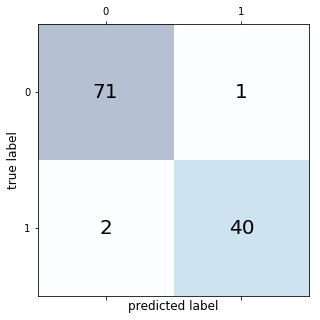

In [25]:
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center', size=20)

plt.xlabel('predicted label', size=12)
plt.ylabel('true label', size=12)
plt.show()

What we can infer is that if class 1 is **Malignant** then our model predicted correctly 40 malignant tumors and 71 belonging to class 0. Though the model predicted as well as non-malignant 2 samples that were actually malignant, and 1 as malignant that wasn't.

### Optimizing precision and recall

Prediction error and accuracy provide general information about how many samples were misclassified. **Error** is the sum of all wrong predictions divided by the total number of predictions:

$$
ERR=\frac{FP+FN}{FP+FN+TN+TP}
$$

While **accuracy** is the opposite, or

$$
ACC=\frac{TP+TN}{FP+FN+TN+TP}=1-ERR
$$

Here we consider $TP$ to indicate **True Positives**, $TN$ **True Negatives**, $FP$ **False Positives** and $FN$ **False Negatives**.

**TPR (True positive rate)** and **FPR (False positive rate)** are useful for imbalanced classes classification problems.

$$
FPR=\frac{FP}{N}=\frac{FP}{FP+TN}
$$

$$
TPR=\frac{TP}{P}=\frac{TP}{FN+TP}
$$

With **FPR** we control that - for instance - we are not predicting as benign what really are malignant tumors and viceversa. 

**Precision (PRE)** and **Recall (REC)** are related to true positive and true negative rates:

$$
PRE=\frac{TP}{TP+FP}
$$

$$
REC=\frac{FP}{FN+TP}
$$

Usually **F1 score** is used which combines both precision and recall:

$$
F1=2\frac{PRE\times REC}{PRE+REC}
$$

We find all these metrics in the scikit-learn [**metrics**](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module.

In [27]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

In [28]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


Furthermore we can use a different scoring metric instead of 'accuracy' in Gridsearch. 

> Remember that the positive class for scikit-learn is 1, if we want a different positive label we can use the [**make_scorer**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) function

In [29]:
from sklearn.metrics import make_scorer, f1_score

In [30]:
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring=scorer,
    cv=10
)

### Plotting a receiver operating characteristic

**Receiver Operating Characteristic (ROC)** are useful tools for selecting models for classification based on their performance on false positive and true positive rates. A perfect classifier would fall on the top left of the chart, with a true positive rate of 1 and false positive rate of 0.

Based on this curve we can calculate as well the **Area under the curve (AUC)**.

To make the curve more interesting we are going to use only two features from the dataset.

In [31]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

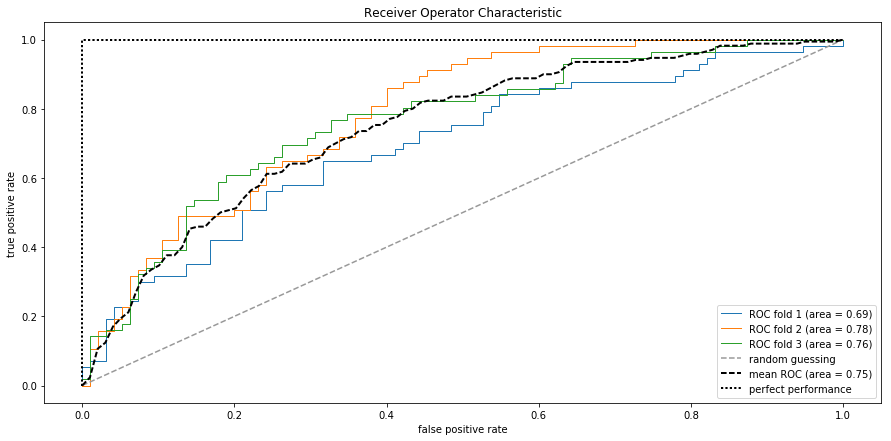

In [33]:
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('clf', LogisticRegression(penalty='l2', 
                               random_state=0,
                               C=100.0))
])
x_train2 = x_train[:, [4, 14]]
cv = list(StratifiedKFold(n_splits=3, 
                              random_state=1).split(x_train, y_train))

fig = plt.figure(figsize=(15,7))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(x_train2[train],
                         y_train[train]).predict_proba(x_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr,tpr)
    
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)' 
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(.6, .6, .6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

What we did is calculate the performance of our pipeline by using the [**roc_curve**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) function for every iteration, moreover we interpolated the average ROC curve via the [**interp**](https://docs.scipy.org/doc/scipy-0.18.1/reference/interpolate.html) function and calculated the area under the curve via the [**auc**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) function.

The result is a ROC curve falling between the perfect score (1) and random guessing (0.5) at 0.75. If we are just interested in the ROC AUC score we can import the [**roc_auc_score**](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) function.

In [34]:
pipe_lr = pipe_lr.fit(x_train2, y_train)
y_pred2 = pipe_lr.predict(x_test[:, [4, 14]])

In [35]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [36]:
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))

ROC AUC: 0.662


In [37]:
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

Accuracy: 0.711


### Scoring metrics for multiclass classification

The scoring metrics discussed previously are specific to binary classification problems, however scikit-learn implements **macro** and **micro** averaging to extend those methods to multiclass problems via **One vs. All (OvA)** classification.

The micro average of the precision score for a $k$ class system can be calculated as:

$$
PRE_{micro}=\frac{TP_1+...+TP_k}{TP_1+...+TP_k+FP_1+...+FP_k}
$$

The macro average is calculated as the average of scores of different systems:

$$
PRE_{macro}=\frac{PRE_1+...+PRE_K}{k}
$$

Micro averaging is useful if we want to weight each instance or prediction equally, while macro averaging weights all classes equally and evaluates the overall performance of the model.

> In scikit-learn the default for multiclass problems is **weighted macro averaging** which is calculated by weighting the score of each class by the number of true instances when calculating the average. We can change this by using the *average* parameter inside the scoring functions used

In [38]:
pre_scorer = make_scorer(score_func=precision_score,
                         pos_label=1,
                         greater_is_better=True,
                         average='micro')